In [ ]:
# 0. ライブラリとデータの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter

plt.rcParams['font.family'] = 'Hiragino Sans' #日本語フォントを指定（Mac）
# plt.rcParams['font.family'] = 'MS Gothic' #日本語フォントを指定（Windows）

In [6]:
# データ読み込み
url = "https://raw.githubusercontent.com/Ginnya-v2/customer_analysis/refs/heads/master/01_CustomerSubscriptionDataset/02_make_simple_dashboard/00_dataset/data.csv"
df = pd.read_csv(url)
df.head()


,ケースID,日時,顧客ID,年齢,性別,商品,契約日時,キャンセル日時,商品名,価格,更新期間
0,CC52120,2019-01-01 07:56:58,C29793,62,female,prd_1,2019-01-01 08:00:46,NaN,annual_subscription,1200,12
1,CC52122,2019-01-01 08:05:10,C29794,61,male,prd_1,2019-01-01 08:09:32,NaN,annual_subscription,1200,12
2,CC52124,2019-01-01 08:44:32,C29795,58,male,prd_1,2019-01-01 08:45:42,NaN,annual_subscription,1200,12
3,CC52126,2019-01-01 08:54:33,C29796,58,male,prd_1,2019-01-01 08:58:46,NaN,annual_subscription,1200,12
4,CC52127,2019-01-01 08:56:58,C29797,72,female,prd_1,2019-01-01 08:59:29,NaN,annual_subscription,1200,12


In [10]:
# 日付変換
df['契約日時'] = pd.to_datetime(df['契約日時'], errors='coerce')
df['キャンセル日時'] = pd.to_datetime(df['キャンセル日時'], errors='coerce')
df['キャンセルまでの日数'] = (df['キャンセル日時'] - df['契約日時']).dt.days

df['キャンセル有無'] = df['キャンセル日時'].notna().astype(int)

,ケースID,日時,顧客ID,年齢,性別,商品,契約日時,キャンセル日時,商品名,価格,更新期間,キャンセルまでの日数,キャンセル有無
count,102182,102182,102182,102182.000000,102182,102182,102182,6401,102182,102182.000000,102182.000000,6401.000000,102182.000000
unique,102182,101912,102182,NaN,2,2,NaN,NaN,2,NaN,NaN,NaN,NaN
top,CC330527,2021-02-08 11:46:29,C131974,NaN,male,prd_1,NaN,NaN,annual_subscription,NaN,NaN,NaN,NaN
freq,1,3,1,NaN,53024,54071,NaN,NaN,54071,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,56.907185,NaN,NaN,2020-07-03 13:09:17.642726144,2021-04-21 09:47:13.230901760,NaN,693.850923,6.820800,390.580847,0.062643
min,NaN,NaN,NaN,23.000000,NaN,NaN,2019-01-01 08:00:46,2019-10-01 09:07:23,NaN,125.000000,1.000000,1.000000,0.000000
25%,NaN,NaN,NaN,50.000000,NaN,NaN,2019-10-11 10:15:02.500000,2020-11-08 20:25:25,NaN,125.000000,1.000000,176.000000,0.000000
50%,NaN,NaN,NaN,57.000000,NaN,NaN,2020-07-02 11:56:04.500000,2021-10-10 09:03:45,NaN,1200.000000,12.000000,308.000000,0.000000
75%,NaN,NaN,NaN,65.000000,NaN,NaN,2021-04-02 10:36:32.750000128,2021-11-19 15:42:17,NaN,1200.000000,12.000000,580.000000,0.000000
max,NaN,NaN,NaN,78.000000,NaN,NaN,2021-12-31 15:37:13,2021-12-31 19:26:18,NaN,1200.000000,12.000000,1091.000000,1.000000


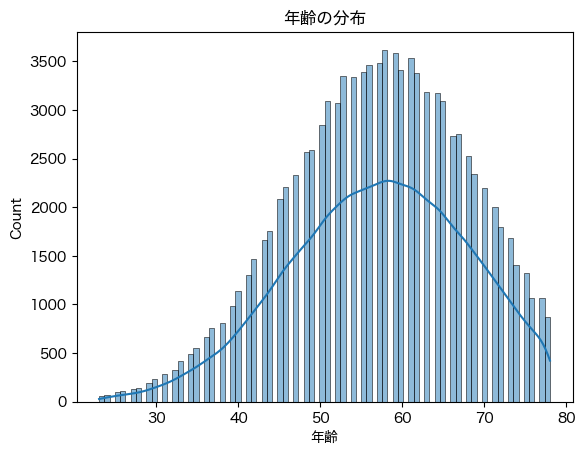

In [14]:
# 1. 基本統計量の確認
display(df.describe(include='all'))
sns.histplot(df['年齢'], kde=True)
plt.title("年齢の分布")
plt.show()

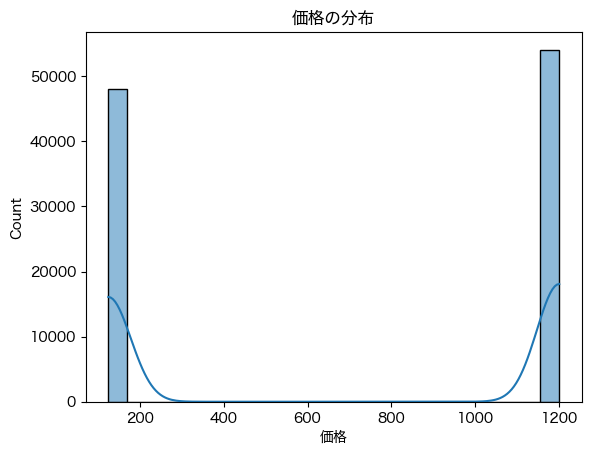

In [15]:
sns.histplot(df['価格'], kde=True)
plt.title("価格の分布")
plt.show()

キャンセル有無         0         1
性別                         
female   0.938464  0.061536
male     0.936331  0.063669


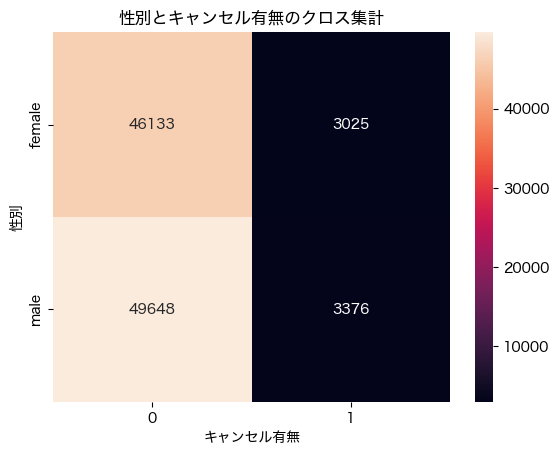

In [16]:
# 2. クロス集計とカテゴリ変数の分布
print(pd.crosstab(df['性別'], df['キャンセル有無'], normalize='index'))
sns.heatmap(pd.crosstab(df['性別'], df['キャンセル有無']), annot=True, fmt="d")
plt.title("性別とキャンセル有無のクロス集計")
plt.show()

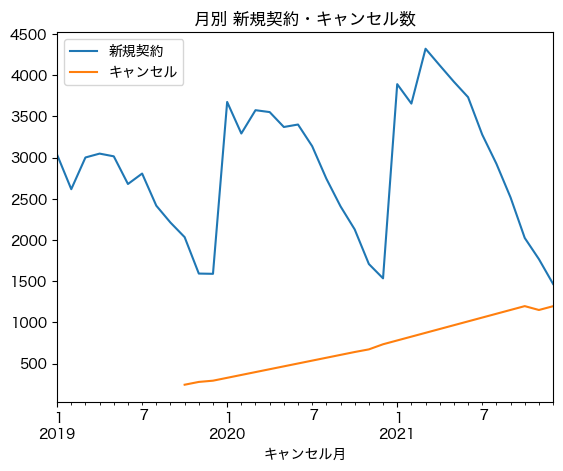

In [18]:
# 3. 時系列分析（月別契約・キャンセル数）
df['契約月'] = df['契約日時'].dt.to_period('M')
df['キャンセル月'] = df['キャンセル日時'].dt.to_period('M')
monthly_new = df.groupby('契約月').size()
monthly_cancel = df.dropna(subset=['キャンセル月']).groupby('キャンセル月').size()

monthly_new.plot(label='新規契約')
monthly_cancel.plot(label='キャンセル')
plt.legend()
plt.title("月別 新規契約・キャンセル数")
plt.show()

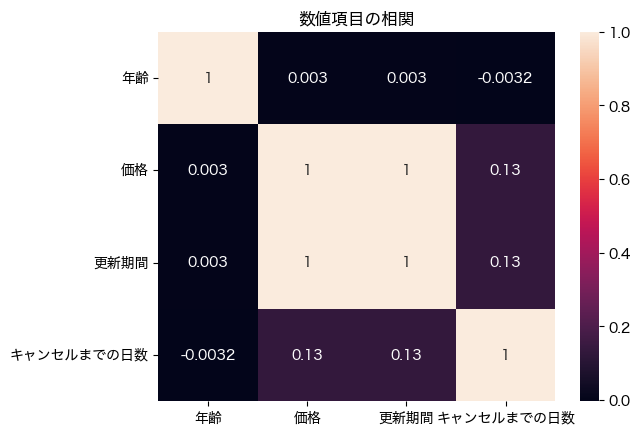

In [19]:
# 4. 相関分析
sns.heatmap(df[['年齢', '価格', '更新期間', 'キャンセルまでの日数']].corr(), annot=True)
plt.title("数値項目の相関")
plt.show()

In [20]:
# 5. 仮説検定
group_f = df[df['性別'] == 'female']['価格']
group_m = df[df['性別'] == 'male']['価格']
t_stat, p_val = stats.ttest_ind(group_f, group_m)
print(f"t検定（男女の価格差）: t={t_stat:.3f}, p={p_val:.3f}")

t検定（男女の価格差）: t=1.347, p=0.178


In [21]:
contingency = pd.crosstab(df['性別'], df['キャンセル有無'])
chi2, p, _, _ = stats.chi2_contingency(contingency)
print(f"カイ二乗検定（性別とキャンセル有無）: chi2={chi2:.3f}, p={p:.3f}")

カイ二乗検定（性別とキャンセル有無）: chi2=1.940, p=0.164


In [22]:
# 6. ロジスティック回帰（キャンセル予測）
df['性別コード'] = df['性別'].map({'male': 0, 'female': 1})
model = smf.logit('キャンセル有無 ~ 年齢 + 性別コード + 価格 + 更新期間', data=df).fit()
print(model.summary())

         Current function value: 0.233559
         Iterations: 35


/Users/sawayanagidaisuke/Documents/2nd_work/customer_analysis/.00_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                キャンセル有無   No. Observations:               102182
Model:                          Logit   Df Residuals:                   102177
Method:                           MLE   Df Model:                            4
Date:                   木, 29  5 2025   Pseudo R-squ.:                0.002646
Time:                        07:20:20   Log-Likelihood:                -23866.
converged:                      False   LL-Null:                       -23929.
Covariance Type:            nonrobust   LLR p-value:                 2.047e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3492        nan        nan        nan         nan         nan
年齢             0.0004      0.001      0.306      0.760      -0.002       0.003
性別コード         -0.0352      0.026     -1.360      0.1

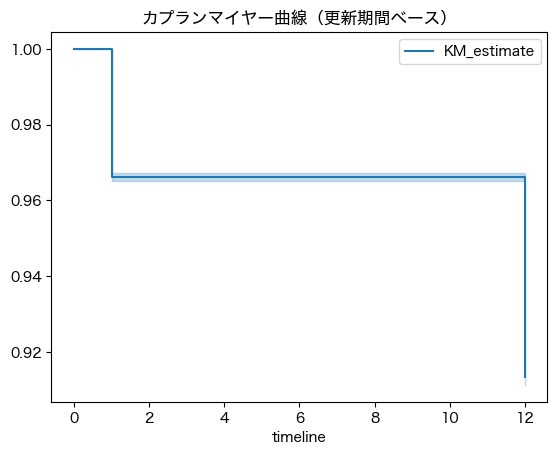

In [23]:
# 7. サバイバル分析
kmf = KaplanMeierFitter()
kmf.fit(df['更新期間'], event_observed=df['キャンセル有無'])
kmf.plot()
plt.title("カプランマイヤー曲線（更新期間ベース）")
plt.show()